In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hmmlearn import hmm
import torch
import torch.nn as nn

from model.PDV import *
from model.HMM import *
from model.data import *

# Data

In [2]:
window = 1000
log_return = True
predict_t_plus_1 = False

In [3]:
start_date = pd.to_datetime('1995-01-01')
end_date = pd.to_datetime('2023-08-31')
spx_data = pd.read_csv('spx_data_nn.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('vix_data_nn.csv', index_col=0, parse_dates=[0])
spx_data.index = pd.to_datetime(pd.to_datetime(spx_data.index, utc=True).date)
vix_data.index = pd.to_datetime(pd.to_datetime(vix_data.index, utc=True).date)
data = create_df_from_yf(spx_data, vix_data, start_date, end_date, predict_t_plus_1=predict_t_plus_1, log_return=log_return)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2023-08-24,-0.013549,1.835850e-04,0.1720
2023-08-25,0.006696,4.482973e-05,0.1568
2023-08-28,0.006245,3.900101e-05,0.1508
2023-08-29,0.014404,2.074772e-04,0.1445


In [8]:
# spx_model = SPXHMM(2, μ=np.ones(2)*1e-4, σ=np.ones(2)*1e-2, π_alpha=[50,1], A_alpha=np.ones((2,2)))
spx_model = SPXHMM(2, μ=[0.1, -0.05], σ=[0.2, 0.4], π_alpha=[10,1], A_alpha=np.ones((2,2)))
print(spx_model.μ, spx_model.σ)
spx_model.EM_optimise(spx_data, tol=1e-5)

[ 0.1  -0.05] [0.2 0.4]
Iteration 1: log likelihood = 17045.22433132329 

Transition likelihood decreased from -2881.522585207576 to -3000.8050010966936
Iteration 2: log likelihood = 18788.340706190895 

Transition likelihood decreased from -3000.8050010966936 to -3164.688712982661
Iteration 3: log likelihood = 18829.86938059165 

Transition likelihood decreased from -3164.688712982661 to -3294.031736932173
Iteration 4: log likelihood = 18899.609534573738 

Transition likelihood decreased from -3294.031736932173 to -3389.950667074758
Iteration 5: log likelihood = 18978.295423515316 

Transition likelihood decreased from -3389.950667074758 to -3459.8226871258175
Iteration 6: log likelihood = 19053.088701124125 

Transition likelihood decreased from -3459.8226871258175 to -3511.349400205023
Iteration 7: log likelihood = 19117.72989734521 

Transition likelihood decreased from -3511.349400205023 to -3550.610625250477
Iteration 8: log likelihood = 19170.38598228693 

Transition likelihood 

In [9]:
spx_model.print_params()

μ:       [0.232 0.102]
σ:       [0.05  0.234]
π_alpha: [25.998  1.002]
π:       [9.999e-01 8.347e-05]
A_alpha: 
[[ 2148.526 19891.583]
 [19880.953 73474.938]]
A:       
[[0.097 0.903]
 [0.213 0.787]]


7214
Model score: 23090.0362
Model score: 23340.0355


Model is not converging.  Current: 23341.37259823062 is not greater than 23341.372668666234. Delta is -7.043561345199123e-05


Model score: 23341.3722
Model score: 23339.9410


Model is not converging.  Current: 23407.382794331705 is not greater than 23407.382921299908. Delta is -0.00012696820340352133


Model score: 23407.3823


Model is not converging.  Current: 23344.910201918614 is not greater than 23344.91215957438. Delta is -0.0019576557679101825


Model score: 23344.9060
Model score: 23209.0629
Model score: 23339.3731
Best model: 4
Regime 0 count: 2992
Regime 1 count: 99
Regime 2 count: 612
Regime 3 count: 3511


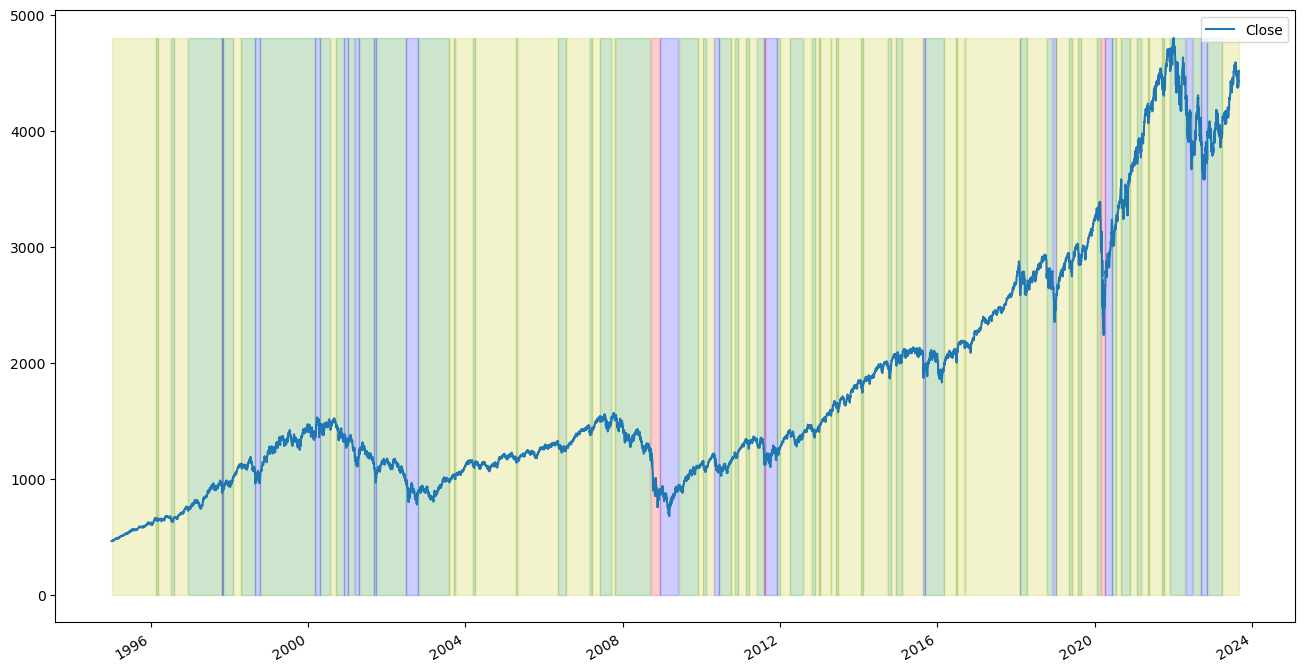

In [27]:
n_models = 8
models = []

log_returns = np.log(spx_data['Close']).diff().dropna().values[:,np.newaxis]
episode_len = len(data) - 1
print(episode_len)

n_regimes = 4
means = np.ones(3)*1e-4
covar = np.eye(3)*1e-4
start_prob = np.array([0.05, 0.95]) # using high prob for regime 0 helps in stablising the permutation

for _ in range(n_models):
    # model = hmm.GaussianHMM(n_components=n_regimes, covariance_type='full', means_prior=means, covars_prior=covar, startprob_prior=start_prob,
    #     n_iter=100, tol=1e-7)
    # model.init_params = ''
    model = hmm.GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=100, tol=1e-7)
    models.append(model)

high_score = 0
for i in range(n_models):
    x = log_returns
    models[i].fit(x)
    preds = models[i].predict(log_returns)

    # if using real data
    print(f'Model score: {models[i].score(x):0.4f}')

    model_score = models[i].score(x)
    if model_score > high_score:
        best_model = i
        high_score = model_score
        best_preds = preds

print(f'Best model: {best_model}')

regimes = best_preds

plt.figure(figsize=(16, 9))
bool_regimes = []

for i in range(n_regimes):
    print(f'Regime {i} count: {(best_preds == i).sum()}')

colors = ['g', 'r', 'b', 'y']

spx_data['Close'].plot()

for i in range(n_regimes):
    bool_regimes.append([np.array(episode_regimes) == i for episode_regimes in regimes])
    plt.fill_between(spx_data.index[1:], spx_data['Close'].values.max(), where=bool_regimes[i], alpha=0.2, color=colors[i])

plt.legend()

In [29]:
drift = models[best_model].means_.squeeze()
volatility = models[best_model].covars_.squeeze() ** 0.5
transition = models[best_model].transmat_
mu = (drift - volatility ** 2 / 2) * 252
sigma = volatility * np.sqrt(252)
print(mu, sigma, mu - sigma ** 2 / 2)
print(transition)

[-0.04225868 -1.96071751 -0.19859255  0.26606403] [0.18611902 0.74503441 0.33010877 0.09506256] [-0.05957883 -2.23825565 -0.25307845  0.26154559]
[[9.68356449e-01 1.56824097e-03 6.34212226e-03 2.37331879e-02]
 [1.19499229e-09 9.58257373e-01 4.17426256e-02 5.07335482e-32]
 [3.50996718e-02 6.50072149e-06 9.64893820e-01 7.75342250e-09]
 [1.96328154e-02 1.85455019e-05 4.86949178e-04 9.79861690e-01]]


# PDV model for VIX

In [4]:
pdv_initial_params = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
vix_model = PDV2Exp(pdv_initial_params)
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
vix_model.optimise(data, window, lower_bound=lower_bound, upper_bound=upper_bound)
print(vix_model.params)
vix_model.evaluate(data, window)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9078e+00                                    3.06e+01    
       1              2         1.7759e+00      1.32e-01       3.63e+00       1.18e+01    
       2              3         1.7013e+00      7.46e-02       2.94e+00       2.39e-01    
       3              4         1.7002e+00      1.04e-03       1.46e+00       4.28e-01    
       4              5         1.7001e+00      1.68e-04       2.17e+00       4.07e-02    
       5              6         1.7000e+00      1.75e-05       8.13e-01       1.12e-02    
       6              7         1.7000e+00      4.01e-06       5.28e-01       3.32e-03    
       7              8         1.7000e+00      1.22e-06       2.84e-01       9.84e-04    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.9078e+00, final cost 1.7000e+00, first-order optimality 9.84e-04.
[ 5.40639378e-02 -5.64113523e-02 

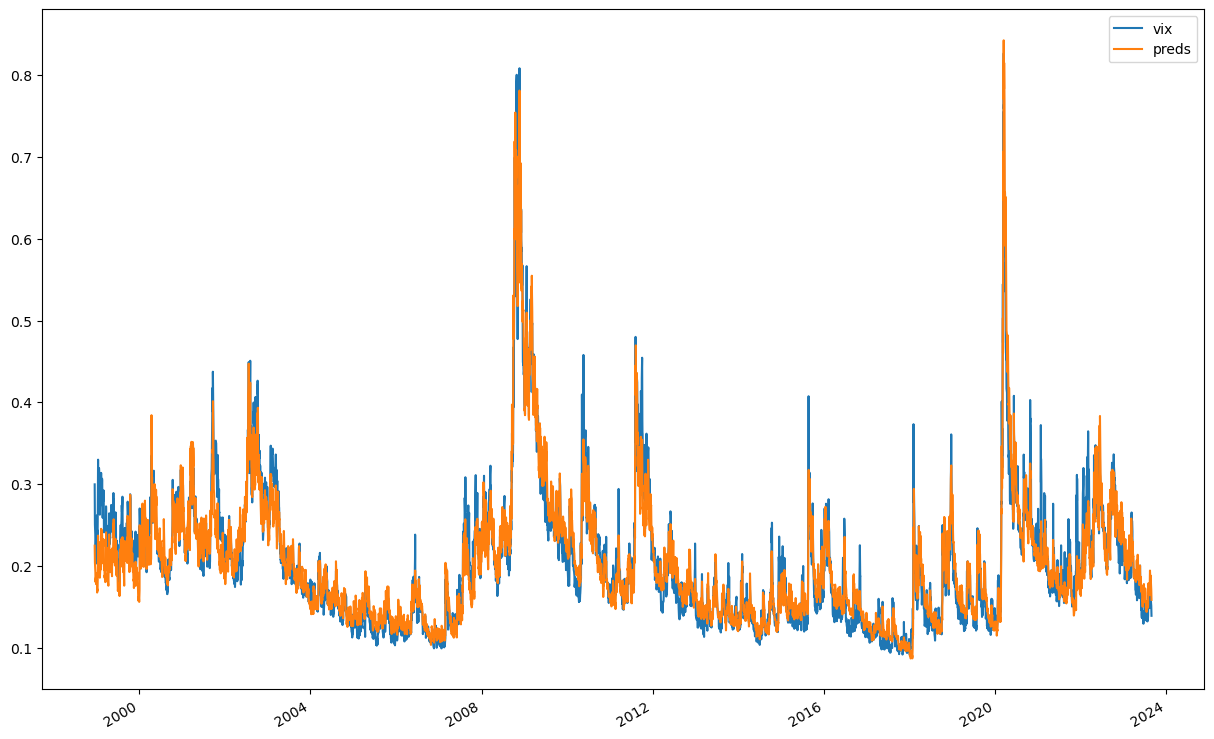

In [5]:
vix_model.plot(data, window)

# HMM for SPX

In [12]:
from scipy.stats import norm
obs = np.random.normal(0, 1, 10)
means = np.array([0, 1, -1])
stds = np.array([1, 2, 2])
norm.logpdf(obs[:,np.newaxis], means[np.newaxis,:], stds[np.newaxis,:]).shape

(10, 3)

In [14]:
from scipy.stats import dirichlet
dirichlet.rvs([1, 1, 1], size=3)

array([[0.69466821, 0.00464425, 0.30068753],
       [0.2167199 , 0.21102038, 0.57225972],
       [0.13788113, 0.82091965, 0.04119922]])